In [1]:
import os
import sys
sys.path.append('utils')
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from pandas.tseries.offsets import Day, Minute, Hour
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
import math
import types

from dataset.spot import SlidingWindow, SPOT
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mae(pred, y_true, mode='default'):
    if mode == 'max':
        out = np.abs(pred.reshape(-1, 24).max(axis=-1) - y_true.reshape(-1, 24).max(axis=-1)).mean()
    elif mode == 'min':
        out = np.abs(pred.reshape(-1, 24).min(axis=-1) - y_true.reshape(-1, 24).min(axis=-1)).mean()
    else:
        out = np.abs(pred - y_true).mean()
    return out

def rmse(pred, y_true):
    out = np.power((pred - y_true), 2).mean()
    return math.sqrt(out)

def mape(pred, y_true, threshold=1e-2):
    pred.reshape(y_true.shape)
    f = lambda o,c: (math.fabs((o-c) / float(o)))*1.0 if math.fabs(o) > threshold else np.nan
    f = np.vectorize(f)
    error = f(y_true, pred)    
    errorCnts = error.shape[0]-np.sum(np.isnan(error),axis=0)
    error = np.nan_to_num(error)
    return np.sum(error, axis=0) / errorCnts

In [3]:
sw = SlidingWindow('2015-12-31')
start_date = "2016-01-01"

In [4]:
Xtrain = sw.X
Ytrain = sw.Y
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
model = MultiOutputRegressor(SVR(kernel='poly', degree=3, gamma='auto', coef0=20.0), n_jobs=30).fit(Xtrain, Ytrain)

In [5]:
Y_hat=model.predict(Xtrain)
Y_hat

array([[12.80717298, 11.7611144 ,  9.10717318, ..., 31.68679889,
        31.68778347, 23.9590826 ],
       [28.420928  , 23.44744654, 18.10014751, ..., 34.00780876,
        33.21185636, 21.64320764],
       [17.95265902, 16.23497972,  9.08880461, ..., 33.17340995,
        29.84028775, 29.16556656],
       ...,
       [35.87732195, 33.21280198, 32.88335944, ..., 47.38494566,
        39.27152115, 37.30951502],
       [36.90123393, 32.67066003, 30.14496774, ..., 47.14712689,
        38.14372061, 36.95766651],
       [36.55952234, 35.87846642, 35.13238789, ..., 50.46712979,
        47.21364458, 38.90621359]])

In [6]:
mae(Y_hat, Ytrain), rmse(Y_hat, Ytrain)

(1.6754034788765801, 4.2310197031461945)

In [7]:
dt = pd.to_datetime(start_date)
track_dates = []
predictions = []

In [8]:
for _ in trange(182):
    track_dates.append(dt)
    
    features = sw.get_features(dt)

    Xtest = scaler.transform(np.expand_dims(features,axis=0))
    pred = model.predict(Xtest)[0]
    predictions.append(pred)
    
    dt+=Day(1)

100%|██████████| 182/182 [00:15<00:00, 11.99it/s]


In [9]:
y_true = SPOT["2016-01-01":"2016-06-30"].values
y_out = np.array(predictions).reshape(4368)

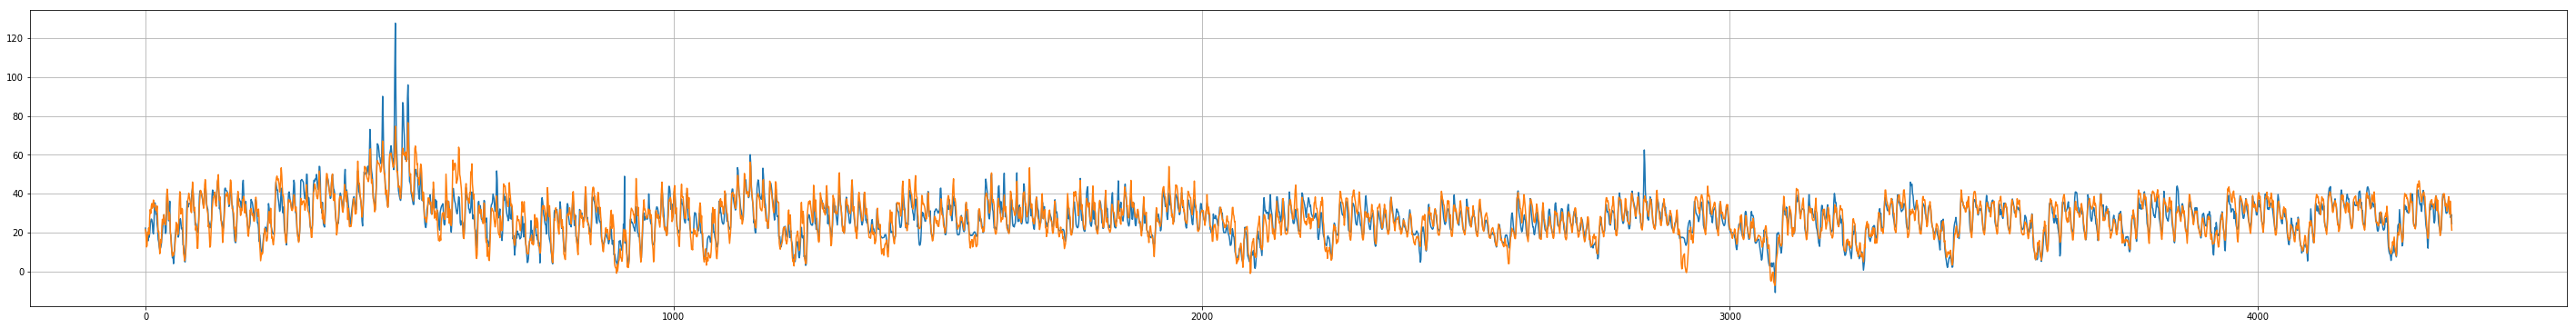

In [10]:
# plot
plt.figure(figsize=(50,6))
plt.plot(y_true)
plt.plot(y_out)
plt.grid()

In [11]:
mae(y_out, y_true), rmse(y_out, y_true), mape(y_out, y_true)

(3.695896354655109, 4.996266568417081, 0.16366948661976113)

In [12]:
# baseline/kernel='poly', degree=3, gamma='auto', coef0=0.0
# (6.585641189178466, 8.385580236341449, 0.3493886430647863)
# kernel='poly', degree=3, gamma='auto', coef0=1.0
# (3.255896479457468, 4.496028421085145, 0.14943447047487232)
# kernel='poly', degree=3, gamma='auto', coef0=3.0
# (3.237774528123799, 4.4825382501283215, 0.1465436148740847)
# kernel='poly', degree=3, gamma='auto', coef0=10.0 *****
# (3.522902497666621, 4.799360328612559, 0.1567565776703639)
# kernel='poly', degree=3, gamma='auto', coef0=15.0
# (3.626797347614074, 4.918770310673994, 0.16084622461785542)
# kernel='poly', degree=3, gamma='auto', coef0=20.0
# (3.695896354655109, 4.996266568417081, 0.16366948661976113)

In [13]:
# rolling

In [94]:
model = MultiOutputRegressor(SVR(kernel='poly', degree=3, gamma='auto', coef0=10), n_jobs=30).fit(Xtrain, Ytrain)

In [95]:
dt = pd.to_datetime("2016-06-24")
track_dates = []
predictions = []

track_dates.append(dt)
features = sw.get_features(dt)
Xtest = scaler.transform(np.expand_dims(features,axis=0))
pred = model.predict(Xtest)[0]
predictions.append(pred)
dt+=Day(1)
for _ in trange(61):
    track_dates.append(dt)
    
    features = sw.get_features(dt)
    features[144:168] = pred
    Xtest = scaler.transform(np.expand_dims(features,axis=0))
    pred = model.predict(Xtest)[0]
    predictions.append(pred)
    
    dt+=Day(1)

100%|██████████| 61/61 [00:05<00:00, 12.12it/s]


In [96]:
y_true = SPOT["2016-07-01":"2016-08-31"].values
y_out = np.array(predictions).reshape(62*24)

In [97]:
mae(y_out, y_true), rmse(y_out, y_true), mape(y_out, y_true)

(5.09717413757257, 6.428984965990879, 0.19213072058513264)

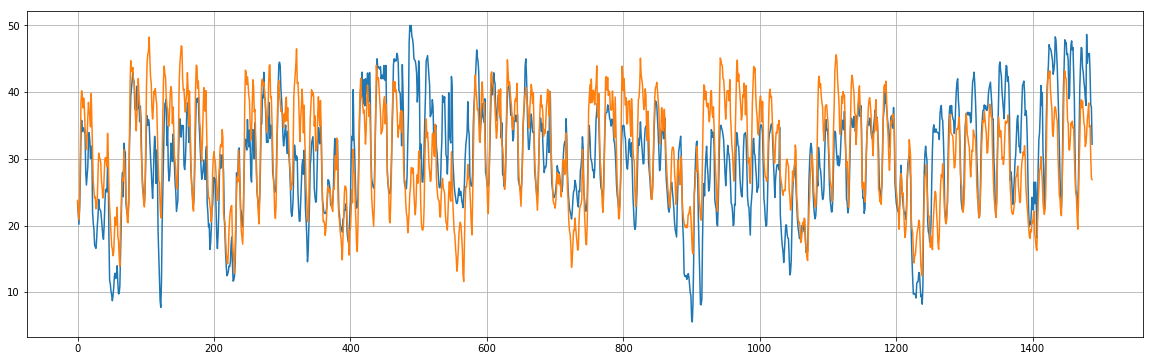

In [98]:
# plot
plt.figure(figsize=(20,6))
plt.plot(y_true)
plt.plot(y_out)
plt.grid()

In [99]:
mae(y_out[:14*24], y_true[:14*24]), rmse(y_out[:14*24], y_true[:14*24]), mape(y_out[:14*24], y_true[:14*24])

(5.029836643747544, 6.2308117844508075, 0.2195447539108628)